# TFM Diseño y desarrollo de un sistema de recomendación

## Autor: Jose Antonio Nazar Aláez

El objetivo principal de este trabajo es profundizar en el conocimiento de los sistemas de recomendación, analizando los diferentes enfoques que existen y aplicando diversos algoritmos al dataset de películas Movielens100k con el fin de comprender su impacto en la experiencia del usuario.

# Librerias

- surprise
https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html
- implicit
https://benfred.github.io/implicit/api/models/gpu/als.html

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from typing import List
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

## FUNCIONES (comunes a los modelos)

In [2]:

def recall_at_k(recommendations: List[int], actually_watched: List[int], k: int = 10) -> float:
    """Compute recall@k for a single user.
    :param recommendations: list of recommended items
    :param actually_watched: list of actually watched items
    :param k: number of top items to consider
    :return: recall@k
    """
    if len(actually_watched) == 0:
        return 0.0  # Retorna 0 si no hay elementos vistos
    return len(set(recommendations[:k]).intersection(actually_watched)) / len(actually_watched)



def precision_at_k(recommendations: List[int], actually_watched: List[int], k: int = 10) -> float:
    """Compute precision@k for a single user.
    :param recommendations: list of recommended items
    :param actually_watched: list of actually watched items
    :param k: number of top items to consider
    :return: precision@k
    """
    return len(set(recommendations[:k]).intersection(actually_watched)) / k



def average_precision_at_k(recommendations: List[int], actually_watched: List[int], k: int = 10) -> float:
    """Compute average precision@k for a single user.
    :param recommendations: list of recommended items
    :param actually_watched: list of actually watched items
    :param k: number of top items to consider
    :return: average precision@k
    """
    if len(recommendations) < k:
        return 0.0
    is_k_recommendation_actually_watched = recommendations[k-1] in actually_watched  # Returns True (1) or False (0)
    return precision_at_k(recommendations, actually_watched, k) * is_k_recommendation_actually_watched



def map_at_k(recommendations: List[int], actually_watched: List[int], k: int = 10) -> float:
    """Compute mean average precision@k for a single user.
    :param recommendations: list of recommended items
    :param actually_watched: list of actually watched items
    :param k: number of top items to consider
    :return: mean average precision@k
    """
    return sum(average_precision_at_k(recommendations, actually_watched, k) for k in range(1, k + 1)) / k



# Lectura de datos

In [3]:
# Cargar los datos de entrenamiento y prueba del dataset movielens100k
train_data = pd.read_csv('C:/Users/Jose/Documents/1-CUNEF/TFM/data/ml-100k/u1.base', delimiter='\t', header=None,
                         names=['user_id', 'item_id', 'rating', 'timestamp'])
test_data = pd.read_csv('C:/Users/Jose/Documents/1-CUNEF/TFM/data/ml-100k/u1.test', delimiter='\t', header=None,
                        names=['user_id', 'item_id', 'rating', 'timestamp'])


In [4]:
# Resto 1 a los user_id y item_id para que los id empiecen en 0 y no en 1 y no haya problemas al crear las matrices.
train_data['user_id'] = train_data['user_id'] - 1
train_data['item_id'] = train_data['item_id'] - 1
test_data['user_id'] = test_data['user_id'] - 1
test_data['item_id'] = test_data['item_id'] - 1


In [5]:
# Creo las matrices para el modelo ALS
train_data_matrix = sp.csr_matrix((train_data['rating'], (train_data['user_id'], train_data['item_id'])), shape=(943, 1682))
test_data_matrix = sp.csr_matrix((test_data['rating'], (test_data['user_id'], test_data['item_id'])), shape=(943, 1682))

# Modelos

- Popularity
- ALS
- KNN (collaborative-filtering)
- NMF
- SVD


### 1. Popularity

Para implementar un modelo que recomiende los elementos más populares del conjunto de datos, se puede utilizar una estrategia simple de "Popularidad". Este enfoque clasifica los elementos en función de su frecuencia de aparición en los datos y recomienda los elementos más populares a los usuarios.

Para ello, se puede utilizar la biblioteca pandas para contar el número de ocurrencias de cada elemento y luego ordenar los elementos por orden de frecuencia de aparición. A continuación, se pueden recomendar los elementos más populares a los usuarios.

In [6]:
# Contar la frecuencia de aparición de cada item
item_popularity = train_data['item_id'].value_counts()


In [7]:
# Leo el dataframe donde se encuentran los títulos de las películas
movies = pd.read_csv('C:/Users/Jose/Documents/1-CUNEF/TFM/data/ml-100k/u.item', delimiter='|', header=None, encoding="ISO-8859-1",
                     names=['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
                            'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
                            'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Resto 1 a los id de los items para que empiecen en 0
movies['item_id'] = movies['item_id'] - 1

movies.head()


,item_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
def popular_recommendation(N=11):
    top_items = item_popularity.index[:N]
    top_movies = movies[movies['item_id'].isin(top_items)]
    top_movies['popularity'] = top_movies['item_id'].map(train_data['item_id'].value_counts()) # Usar count() para la frecuencia
    top_movies = top_movies.sort_values(by='popularity', ascending=False) # Ordenar por frecuencia de aparición
    top_movies = top_movies[['title', 'popularity']] # Seleccionar solo las columnas de título y popularidad
    return top_movies


(

- **def popular_recommendation(user_id, N=10):** Esta es la definición de la función popular_recommendation que toma como elemento de entrada: N, que es el número máximo de elementos populares que se quieren recomendar. El valor predeterminado para N es 10 si no se proporciona.
- **top_items = item_popularity.index[:N]**: Esta línea crea una lista top_items que contiene los N elementos más populares. item_popularity.index representa los índices de los elementos populares (es decir, los ID de los elementos) y [:N] realiza una selección de los primeros N elementos de esa lista
- **top_movies = movies[movies['item_id'].isin(top_items)]:** Esta línea filtra el DataFrame movies para obtener solo las filas cuyo valor en la columna 'item_id' está presente en la lista top_items. Esto devuelve un nuevo DataFrame top_movies que contiene solo las películas correspondientes a los elementos más populares.
- **top_movies['popularity'] = top_movies['item_id'].map(train_data['item_id'].value_counts()):** Esta línea crea una nueva columna 'popularity' en el DataFrame top_movies que contiene la frecuencia de aparición de cada película en los datos de entrenamiento (train_data). Se utiliza la función map() para mapear los valores de 'item_id' en top_movies con la frecuencia de aparición correspondiente obtenida a través de train_data['item_id'].value_counts().
- **top_movies = top_movies.sort_values(by='popularity', ascending=False):** Esta línea ordena el DataFrame top_movies por la columna 'popularity' en orden descendente, es decir, de mayor a menor frecuencia de aparición, utilizando la función sort_values(). El argumento by='popularity' especifica que se ordene por la columna 'popularity', y ascending=False indica que se ordene en orden descendente
- **top_movies = top_movies[['title', 'popularity']]:** Esta línea selecciona solo las columnas 'title' y 'popularity' del DataFrame top_movies utilizando la notación de índice doble ([['title', 'popularity']]). Esto crea un nuevo DataFrame top_movies que contiene solo las columnas de título y popularidad.
- **return top_movies:** Esta línea devuelve el DataFrame top_movies que contiene el título de las películas y su frecuencia de aparición en los datos de entrenamiento, ordenado por frecuencia de aparición en orden descendente, como resultado de la función.

)

In [9]:
# Se imprimen las 10 peliculas más populares
print(popular_recommendation())

                              title  popularity
49                 Star Wars (1977)         484
180       Return of the Jedi (1983)         422
257                  Contact (1997)         402
99                     Fargo (1996)         395
293                Liar Liar (1997)         394
287                   Scream (1996)         391
285     English Patient, The (1996)         388
0                  Toy Story (1995)         383
120   Independence Day (ID4) (1996)         353
299            Air Force One (1997)         352
173  Raiders of the Lost Ark (1981)         344


**Recall@K**

El "Recall@k" es una métrica que se utiliza comúnmente en la evaluación de sistemas de recomendación y en problemas de recuperación de información. El "recall" (recuperación) se refiere a la proporción de elementos relevantes que son recuperados correctamente en relación con el total de elementos relevantes en un conjunto de datos.

In [10]:
# Paso la función que calcula las recomendaciones populares a una lista
def popular_recommendation(N=11):
    top_items = item_popularity.index[:N]
    top_movies = movies[movies['item_id'].isin(top_items)]
    top_movies['popularity'] = top_movies['item_id'].map(train_data['item_id'].value_counts()) # Usar count() para la frecuencia
    top_movies = top_movies.sort_values(by='popularity', ascending=False) # Ordenar por frecuencia de aparición
    top_movies = top_movies[['item_id', 'title', 'popularity']] # Seleccionar solo las columnas de título y popularidad
    return top_movies['item_id'].tolist()


In [11]:
recommended_items = popular_recommendation()

In [12]:
# Lista de valores de k a calcular
k_values = [1, 3, 5, 10]

# Calcular recall@k promedio para todos los usuarios para cada valor de k
for k in k_values:
    recall_sum = 0
    total_users = len(test_data['user_id'].unique())
    for user_id in test_data['user_id'].unique():
        recall = recall_at_k(recommended_items, test_data[test_data['user_id'] == user_id]['item_id'].tolist(), k=k)
        recall_sum = recall_sum + recall

    recall_avg = recall_sum / total_users
    print(f"Recall@{k} {recall_avg}")


Recall@1 0.008187100114181998
Recall@3 0.024490670856017645
Recall@5 0.03970955755326808
Recall@10 0.07477571352205586


- **Recall@1: 0.0082**, significa que en promedio, solo el 0.82% de las películas relevantes para cada usuario fueron recomendadas en el top 1.
- **Recall@3: 0.0245**, significa que en promedio, el sistema de recomendación acierta con el 2.45% de las películas relevantes en el top 3 de recomendaciones. 
- **Recall@5: 0.0397**, significa que en promedio, el sistema de recomendación acierta con el 3.97% de las películas relevantes en el top 5 de recomendaciones. 
- **Recall@10: 0.0747**, significa que en promedio, el sistema de recomendación acierta con el 7.48% de las películas relevantes en el top 10 de recomendaciones. 

**Precision@K**

El "Precision@k" es otra métrica utilizada en la evaluación de sistemas de recomendación y en problemas de recuperación de información. La precisión (precision) se refiere a la proporción de elementos recuperados correctamente, que son realmente relevantes en relación con el total de elementos recuperados.

In [13]:
def calculate_precision_at_k_popularity(recommended_items, test_data, k_values):
    """Calculate precision@k for a list of k values.
    :param recommended_items: list of recommended items for all users
    :param test_data: test data containing user-item interactions
    :param k_values: list of k values to calculate precision@k
    """
    for k in k_values:
        precision_sum = 0
        total_users = len(test_data['user_id'].unique())
        for user_id in test_data['user_id'].unique():
            precision = precision_at_k(recommended_items, test_data[test_data['user_id'] == user_id]['item_id'].tolist(), k=k)
            precision_sum = precision_sum + precision

        precision_avg = precision_sum / total_users
        print(f"Precision@{k} {precision_avg}")


In [14]:
# Lista de valores de k a calcular
k_values = [1, 3, 5, 10]

# Calcular precision@k promedio para todos los usuarios para cada valor de k
calculate_precision_at_k_popularity(recommended_items, test_data, k_values)


Precision@1 0.21568627450980393
Precision@3 0.21132897603485803
Precision@5 0.21568627450980477
Precision@10 0.19586056644880145


- **Precision@1: 0.2157**
Esto significa que, en promedio, el 21.57% de las recomendaciones realizadas por el sistema de recomendación fueron correctas para el primer elemento recomendado.

- **Precision@3: 0.2113**
En este caso, el Precision@3 indica que, en promedio, el 21.13% de las recomendaciones realizadas por el sistema de recomendación fueron correctas para los tres primeros elementos recomendados.

- **Precision@5: 0.2157**
Para el Precision@5, el valor obtenido indica que, en promedio, el 21.57% de las recomendaciones realizadas por el sistema de recomendación fueron correctas para los cinco primeros elementos recomendados.

- **Precision@10: 0.1959**
El Precision@10 indica que, en promedio, el 19.59% de las recomendaciones realizadas por el sistema de recomendación fueron correctas para los diez primeros elementos recomendados.

**Map@K**

El término "MAP@k" (Mean Average Precision at k) es una métrica comúnmente utilizada para evaluar sistemas de recuperación de información y sistemas de recomendación. El MAP@k mide la precisión promedio de un sistema al recuperar elementos relevantes en los primeros "k" resultados.

In [15]:
def map_at_k_popularity(recommended_items: List[int], test_data: pd.DataFrame, k_values: List[int]) -> None:
    """Compute MAP@k for each value of k in k_values.
    :param recommended_items: list of recommended items for all users
    :param test_data: test dataset
    :param k_values: list of values of k to calculate MAP@k
    """
    total_users = len(test_data['user_id'].unique())
    for k in k_values:
        ap_sum = 0
        for user_id in test_data['user_id'].unique():
            ap = map_at_k(recommended_items[user_id], test_data[test_data['user_id'] == user_id]['item_id'].tolist(), k=k)
            ap_sum += ap
        map_k = ap_sum / total_users
        print(f"MAP@{k} {map_k}")


In [16]:
# Calcular recomendaciones populares para todos los usuarios
recommended_items = {user_id: popular_recommendation() for user_id in test_data['user_id'].unique()}



In [17]:
# Lista de valores de k a calcular
k_values = [1, 3, 5, 10]

# Calcular MAP@k promedio para todos los usuarios para cada valor de k
map_at_k_popularity(recommended_items, test_data, k_values)

MAP@1 0.21568627450980393
MAP@3 0.14960058097313012
MAP@5 0.1283006535947714
MAP@10 0.09526748971193415


- **El MAP@1: 0.2157** significa que en promedio, para cada usuario en el conjunto de datos, el sistema de recomendación ha proporcionado la recomendación correcta en el primer lugar en el 21.57% de las ocasiones.

- **El MAP@3: 0.1496** significa que en promedio, para cada usuario en el conjunto de datos, el sistema de recomendación ha proporcionado la recomendación correcta en los primeros tres lugares en el 14.96% de las ocasiones.

- **El MAP@5: 0.1283** significa que en promedio, para cada usuario en el conjunto de datos, el sistema de recomendación ha proporcionado la recomendación correcta en los primeros cinco lugares en el 12.83% de las ocasiones.

- **El MAP@10: 0.0953** significa que en promedio, para cada usuario en el conjunto de datos, el sistema de recomendación ha proporcionado la recomendación correcta en los primeros diez lugares en el 9.53% de las ocasiones.

### 2. ALS (Alternating Least Squares)

Es un algoritmo de factorización matricial que se utiliza en sistemas de recomendación de **filtrado colaborativo**. Este modelo se enfoca en encontrar las preferencias latentes de los usuarios y los atributos latentes de los elementos a recomendar. El modelo es entrenado utilizando la información de interacciones usuario-elemento (por ejemplo, calificaciones o visualizaciones) para hacer recomendaciones basadas en la similitud de preferencias entre usuarios y elementos.

In [18]:
from implicit.als import AlternatingLeastSquares

In [19]:
# Defino el modelo
als_model = AlternatingLeastSquares(factors=50, random_state=42)

# Entreno el modelo
als_model.fit(train_data_matrix)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 54.55it/s]


In [20]:
# Crear una lista para almacenar todas las recomendaciones
all_recommended_items = []

# Iterar sobre todos los usuarios
for user_id in range(train_data_matrix.shape[0]):
    # Generar recomendaciones para el usuario actual
    recommended_items = als_model.recommend(user_id, train_data_matrix[user_id], N=10)[0]
    # Agregar las recomendaciones a la lista
    all_recommended_items.append(recommended_items)

# Mostrar las recomendaciones para cada usuario
for user_id, recommended_items in enumerate(all_recommended_items):
    print(f"Recomendaciones para el usuario {user_id}: {recommended_items}")


Recomendaciones para el usuario 0: [ 11  99 745 179 182 731 173  97 747 918]
Recomendaciones para el usuario 1: [ 49 514 256 302 300   8 590  14 312 123]
Recomendaciones para el usuario 2: [285 327 312 271 268 314 300 326 306 330]
Recomendaciones para el usuario 3: [287 293 332 306 325 331 244 269 339 285]
Recomendaciones para el usuario 4: [221  93  81   0  90 229 402 117 201  71]
Recomendaciones para el usuario 5: [247 318 602 356 704  94 479 482 478 587]
Recomendaciones para el usuario 6: [447 126 287 741 199 581 176  21 195 217]
Recomendaciones para el usuario 7: [229  49  21 264 171 567 225 549 160 678]
Recomendaciones para el usuario 8: [126 287 180 236  14  99 133 285 738  96]
Recomendaciones para el usuario 9: [222 503 520 123 339 434 186 683 872 460]
Recomendaciones para el usuario 10: [293 208 288 739 282 201 215  21 193 283]
Recomendaciones para el usuario 11: [203  55 209 152 172  69  63 495  96 285]
Recomendaciones para el usuario 12: [237 177 197 184 332 124 523  23 330 2

**Recall@K**

In [21]:
k_values = [1, 3, 5, 10]
recall_scores = []

for user_id in range(train_data_matrix.shape[0]):
    recommended_items = als_model.recommend(user_id, train_data_matrix[user_id], N=10)[0]
    actually_watched = test_data_matrix.toarray()[user_id].nonzero()[0]
    recall_values = [recall_at_k(recommended_items, actually_watched, k) for k in k_values]
    recall_scores.append(recall_values)

# Calcular el promedio del recall@k para todos los usuarios
recall_scores = np.array(recall_scores)
average_recall = np.mean(recall_scores, axis=0)

# Mostrar el promedio del recall@k
for i, k in enumerate(k_values):
    print(f"Recall@{k}: {average_recall[i]}")


Recall@1: 0.014431978774698893
Recall@3: 0.034624966530438735
Recall@5: 0.051531650405625185
Recall@10: 0.08615780380883957


- **Recall@1: 0.0144** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 1.44% de los elementos relevantes en la lista de recomendaciones más cercanas al primer elemento recomendado para cada usuario.

- **Recall@3: 0.0346** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 3.46% de los elementos relevantes en la lista de recomendaciones más cercanas a los tres primeros elementos recomendados para cada usuario.

- **Recall@5: 0.0515** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 5.15% de los elementos relevantes en la lista de recomendaciones más cercanas a los cinco primeros elementos recomendados para cada usuario.

- **Recall@10: 0.0862** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 8.62% de los elementos relevantes en la lista de recomendaciones más cercanas a los diez primeros elementos recomendados para cada usuario.

**Precision@K**

In [22]:
k_values = [1, 3, 5, 10]
precision_scores = []

for user_id in range(train_data_matrix.shape[0]):
    recommended_items = als_model.recommend(user_id, train_data_matrix[user_id], N=10)[0]
    actually_watched = test_data_matrix.toarray()[user_id].nonzero()[0]
    precision_values = [precision_at_k(recommended_items, actually_watched, k) for k in k_values]
    precision_scores.append(precision_values)

# Calcular el promedio del precision@k para todos los usuarios
precision_scores = np.array(precision_scores)
average_precision = np.mean(precision_scores, axis=0)

# Mostrar el promedio del precision@k
for i, k in enumerate(k_values):
    print(f"Precision@{k}: {average_precision[i]}")


Precision@1: 0.30010604453870626
Precision@3: 0.2583951926475785
Precision@5: 0.2413573700954401
Precision@10: 0.21410392364793204


- **Precision@1: 0.3001** Este resultado indica la proporción de veces que el artículo más recomendado por ALS (el de mayor puntuación) coincide con uno de los artículos que el usuario realmente vio. Un valor de 0.3001 significa que, en promedio, ALS recomienda el artículo que el usuario vio en el 30.01% de los casos.

- **Precision@3: 0.2584** Este resultado es similar al anterior, pero considera los tres artículos más recomendados por ALS. Un valor de 0.2584 indica que, en promedio, ALS recomienda uno de los tres artículos que el usuario vio en el 25.84% de los casos.

- **Precision@5: 0.2414** Este resultado es similar al anterior, pero considera los cinco artículos más recomendados por ALS. Un valor de 0.2414 indica que, en promedio, ALS recomienda uno de los cinco artículos que el usuario vio en el 24.14% de los casos.

- **Precision@10: 0.2141** Este resultado es similar a los anteriores, pero considera los diez artículos más recomendados por ALS. Un valor de 0.2141 indica que, en promedio, ALS recomienda uno de los diez artículos que el usuario vio en el 21.41% de los casos.

**MAP(mean average precision)**

In [23]:
k_values = [1, 3, 5, 10]
map_scores = []

for user_id in range(train_data_matrix.shape[0]):
    recommended_items = als_model.recommend(user_id, train_data_matrix[user_id], N=10)[0]
    actually_watched = test_data_matrix.toarray()[user_id].nonzero()[0]
    map_values = [map_at_k(recommended_items, actually_watched, k) for k in k_values]
    map_scores.append(map_values)

# Calcular el promedio del MAP@k para todos los usuarios
map_scores = np.array(map_scores)
average_map = np.mean(map_scores, axis=0)

# Mostrar el promedio del MAP@k
for i, k in enumerate(k_values):
    print(f"MAP@{k}: {average_map[i]}")


MAP@1: 0.30010604453870626
MAP@3: 0.22929185813597228
MAP@5: 0.19752209261223055
MAP@10: 0.15832394923328097


- **Map@1: 0.3001**
Este valor de MAP@1 significa que, en promedio, el 27.36% de las recomendaciones en la posición 1 del conjunto de recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@3: 0.2293**
Este valor de MAP@3 significa que, en promedio, el 22.93% de las recomendaciones en las primeras 3 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@5: 0.1975**
Este valor de MAP@5 significa que, en promedio, el 19.75% de las recomendaciones en las primeras 5 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@10: 0.1583**
Este valor de MAP@10 significa que, en promedio, el 15.83% de las recomendaciones en las primeras 10 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

### 6. Recomendaciones por género (basado en contenido)

In [24]:
movies.columns

Index(['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [25]:
movie_genres = [
    'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
    'Western'
]

In [26]:
# Añado al dataframe la columna winning_genre donde se incluye el género que más a visto cada usuario
df = (train_data
    .merge(movies, on='item_id', how='inner')
    .groupby(['user_id'], as_index=False)
    .agg({genre: 'sum' for genre in movie_genres})
    .assign(**{'winning_genre': lambda x: x[movie_genres].idxmax(axis=1)})
)

(
1. Combina los conjuntos de datos: El código fusiona los conjuntos de datos train_data y movies utilizando la columna 'item_id' como clave de unión. Esto crea un nuevo DataFrame que contiene información combinada de películas y datos de entrenamiento.


2. Agrupación de datos:
- Agrupa el DataFrame combinado por 'user_id' utilizando groupby. Esto agrupa los datos por usuario, lo que significa que se creará un grupo para cada usuario único en el conjunto de datos.

3. Cálculo de la suma de géneros:
- Utiliza agg para aplicar una función de agregación a cada grupo. En este caso, se utiliza una comprensión de diccionario para iterar sobre cada género en la lista movie_genres y calcular la suma de ese género para cada usuario. El resultado es un DataFrame que muestra la suma de cada género para cada usuario.

4. Asignación del género ganador:
- Utiliza assign para agregar una nueva columna llamada 'winning_genre' al DataFrame resultante.
- La columna 'winning_genre' se calcula utilizando la función lambda para encontrar el género con el valor máximo en cada fila del DataFrame. Se utiliza el método idxmax junto con axis=1 para encontrar el nombre del género con la suma máxima en cada fila.

)

In [27]:
df

,user_id,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,winning_genre
0,0,29,16,7,14,51,11,5,57,1,1,4,5,3,22,19,24,12,1,Drama
1,1,4,1,1,2,9,6,0,23,0,1,1,1,2,13,1,8,2,0,Drama
2,2,6,3,0,0,6,4,1,12,0,1,2,2,5,3,6,9,3,0,Drama
3,3,6,3,0,0,2,3,1,3,0,0,0,1,3,1,3,6,1,0,Action
4,4,31,20,9,13,40,4,0,14,0,0,15,8,2,9,21,7,6,1,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,938,18,10,1,1,15,3,0,18,1,0,1,1,1,10,8,12,3,0,Action
939,939,23,12,2,5,42,7,0,48,0,3,4,7,3,24,19,20,15,0,Drama
940,940,10,7,3,2,7,1,0,5,0,0,0,1,1,1,8,7,1,0,Action
941,941,18,11,4,13,22,0,0,31,2,1,3,5,9,17,6,20,10,3,Drama


In [28]:
# Recomendaciones por género
df2 = (train_data
    .merge(movies, on='item_id', how='inner')
    .melt(id_vars=['user_id', 'item_id', 'rating'], value_vars=movie_genres, var_name='genre')
    .loc[lambda df: df['value'] == 1]
    .groupby(['item_id', 'genre'], as_index=False)
    .agg({'rating': 'mean'})
    .sort_values('rating', ascending=False)
    .reset_index(drop=True)
)

recommendations_by_genre = {}
for genre in movie_genres:
    recommendations_by_genre[genre] = (df2
        .loc[lambda df2: df2['genre'] == genre]
        ['item_id'].values[:10].tolist()
    )

recommendations_by_genre

{'Action': [49, 312, 126, 173, 514, 171, 172, 186, 21, 497],
 'Adventure': [1292, 49, 173, 171, 172, 510, 497, 519, 600, 131],
 'Animation': [1366, 407, 168, 113, 188, 0, 968, 94, 431, 587],
 'Childrens': [1292, 131, 7, 499, 0, 968, 94, 431, 422, 587],
 'Comedy': [1499, 407, 168, 479, 250, 523, 172, 315, 486, 169],
 'Crime': [1121, 11, 1190, 126, 1063, 186, 301, 99, 610, 193],
 'Documentary': [1200, 1593, 849, 118, 319, 1141, 47, 1628, 1129, 1496],
 'Drama': [1466, 1188, 1121, 1652, 1598, 1448, 1641, 317, 482, 63],
 'Fantasy': [1292, 422, 140, 557, 754, 71, 471, 1614, 307, 410],
 'Film-Noir': [487, 1063, 656, 483, 301, 88, 488, 653, 610, 655],
 'Horror': [184, 838, 1624, 182, 207, 442, 199, 852, 233, 1242],
 'Musical': [131, 704, 208, 1202, 964, 94, 431, 185, 587, 142],
 'Mystery': [602, 512, 478, 483, 301, 190, 492, 504, 653, 123],
 'Romance': [482, 49, 312, 965, 171, 172, 486, 184, 169, 477],
 'Sci-Fi': [1292, 49, 473, 171, 88, 180, 95, 182, 175, 170],
 'Thriller': [407, 11, 602, 112

(

Primero, se realiza una serie de transformaciones encadenadas al DataFrame train_data:

- El método merge se utiliza para combinar train_data con movies utilizando la columna 'item_id' como clave de unión, de manera que se obtiene un nuevo DataFrame que contiene la información de las películas correspondientes a los datos de entrenamiento.
- A continuación, se utiliza el método melt para transformar el DataFrame de ancho a largo. Esto implica convertir las columnas de géneros de películas (movie_genres) en filas adicionales. Las columnas 'user_id', 'item_id' y 'rating' se mantienen como columnas identificadoras, mientras que la columna 'value' contiene el valor binario (1 o 0) que indica si la película pertenece al género correspondiente.
- Luego, se utiliza el método loc para filtrar las filas donde el valor de 'value' es igual a 1, es decir, se seleccionan las películas que pertenecen al género específico.
- Después, se agrupa el DataFrame por 'item_id' y 'genre' utilizando el método groupby, y se calcula la media de la columna 'rating' para cada grupo utilizando el método agg.
- Posteriormente, se ordena el DataFrame resultante por la columna 'rating' en orden descendente utilizando el método sort_values.
- Por último, se utiliza reset_index para restablecer el índice del DataFrame.

Luego, se crea un diccionario llamado recommendations_by_genre que almacenará las recomendaciones de películas por género.

- Se inicializa el diccionario vacío.
- Se itera sobre cada género en la lista de movie_genres.
- Para cada género, se realiza una nueva selección en el DataFrame df utilizando loc y se extraen los 10 primeros valores de la columna 'item_id' correspondientes al género específico. Estos valores se convierten en una lista utilizando el método tolist().
- Finalmente, se asigna la lista de recomendaciones al diccionario recommendations_by_genre utilizando el género como clave.
- Finalmente, se devuelve el diccionario recommendations_by_genre, que contiene las recomendaciones de películas por género.

)

In [29]:
df2

,item_id,genre,rating
0,1292,Fantasy,5.0
1,1499,Comedy,5.0
2,1466,Drama,5.0
3,1188,Drama,5.0
4,1200,Documentary,5.0
...,...,...,...
2843,1582,Drama,1.0
2844,857,Horror,1.0
2845,1583,Drama,1.0
2846,1338,Comedy,1.0


**Recall@k**

In [30]:
recall_values = {}  # Diccionario para almacenar los valores de recall@k para cada k
k_values = [1, 3, 5, 10]  # Valores de k para los que deseas calcular el recall

for k in k_values:
    recall_sum = 0.0
    for user_id in df['user_id'].unique():
        user_df = df[df['user_id'] == user_id]
        user_winning_genre = user_df['winning_genre'].iloc[0]
        recommendations = recommendations_by_genre[user_winning_genre][:k]
        actually_watched = test_data[test_data['user_id'] == user_id]['item_id'].tolist()

        recall_sum += recall_at_k(recommendations, actually_watched, k)

    recall_avg = recall_sum / len(df['user_id'].unique())
    recall_values[k] = recall_avg

# Imprimir los resultados
for k, recall in recall_values.items():
    print(f"Recall@{k}: {recall}")


Recall@1: 0.0009306352390147249
Recall@3: 0.0022353019832824636
Recall@5: 0.0032084104524862985
Recall@10: 0.008083344483702395


- **Recall@1: 0.0009** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 0.09% de los elementos relevantes en la lista de recomendaciones más cercanas al primer elemento recomendado para cada usuario.

- **Recall@3: 0.0022** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 0.22% de los elementos relevantes en la lista de recomendaciones más cercanas a los tres primeros elementos recomendados para cada usuario.

- **Recall@5: 0.0032** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 0.32% de los elementos relevantes en la lista de recomendaciones más cercanas a los cinco primeros elementos recomendados para cada usuario.

- **Recall@10: 0.0081** Esto significa que, en promedio, el sistema de recomendación basado en ALS está recuperando solo el 0.81% de los elementos relevantes en la lista de recomendaciones más cercanas a los diez primeros elementos recomendados para cada usuario.

**Precision@k**

In [31]:
precision_values = {}  # Diccionario para almacenar los valores de precision@k para cada k
k_values = [1, 3, 5, 10]  # Valores de k para los que deseas calcular el precision

for k in k_values:
    precision_sum = 0.0
    for user_id in df['user_id'].unique():
        user_df = df[df['user_id'] == user_id]
        user_winning_genre = user_df['winning_genre'].iloc[0]
        recommendations = recommendations_by_genre[user_winning_genre][:k]
        actually_watched = test_data[test_data['user_id'] == user_id]['item_id'].tolist()

        precision_sum += precision_at_k(recommendations, actually_watched, k)

    precision_avg = precision_sum / len(df['user_id'].unique())
    precision_values[k] = precision_avg

# Imprimir los resultados
for k, precision in precision_values.items():
    print(f"Precision@{k}: {precision}")


Precision@1: 0.021208907741251327
Precision@3: 0.021562389536938835
Precision@5: 0.018875927889713665
Precision@10: 0.030116648992576923


- **Precision@1: 0.0212** Este resultado indica la proporción de veces que el artículo más recomendado por ALS (el de mayor puntuación) coincide con uno de los artículos que el usuario realmente vio. Un valor de 0.0212 significa que, en promedio, ALS recomienda el artículo que el usuario vio en el 2.12% de los casos.

- **Precision@3: 0.0216** Este resultado es similar al anterior, pero considera los tres artículos más recomendados por ALS. Un valor de 0.0216 indica que, en promedio, ALS recomienda uno de los tres artículos que el usuario vio en el 2.16% de los casos.

- **Precision@5: 0.0189** Este resultado es similar al anterior, pero considera los cinco artículos más recomendados por ALS. Un valor de 0.0189 indica que, en promedio, ALS recomienda uno de los cinco artículos que el usuario vio en el 1.89% de los casos.

- **Precision@10: 0.0301** Este resultado es similar a los anteriores, pero considera los diez artículos más recomendados por ALS. Un valor de 0.0301 indica que, en promedio, ALS recomienda uno de los diez artículos que el usuario vio en el 3.01% de los casos.

**Map@k**

In [32]:
map_values = {}  # Diccionario para almacenar los valores de MAP@k para cada k
k_values = [1, 3, 5, 10]  # Valores de k para los que deseas calcular el MAP

for k in k_values:
    map_sum = 0.0
    for user_id in df['user_id'].unique():
        user_df = df[df['user_id'] == user_id]
        user_winning_genre = user_df['winning_genre'].iloc[0]
        recommendations = recommendations_by_genre[user_winning_genre][:k]
        actually_watched = test_data[test_data['user_id'] == user_id]['item_id'].tolist()

        map_sum += map_at_k(recommendations, actually_watched, k)

    map_avg = map_sum / len(df['user_id'].unique())
    map_values[k] = map_avg

# Imprimir los resultados
for k, map_value in map_values.items():
    print(f"MAP@{k}: {map_value}")


MAP@1: 0.021208907741251327
MAP@3: 0.014964062684105094
MAP@5: 0.01161894662424885
MAP@10: 0.010090306182564927


- **Map@1: 0.0212**
Este valor de MAP@1 significa que, en promedio, el 2.12% de las recomendaciones en la posición 1 del conjunto de recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@3: 0.0150**
Este valor de MAP@3 significa que, en promedio, el 1.50% de las recomendaciones en las primeras 3 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@5: 0.0116**
Este valor de MAP@5 significa que, en promedio, el 1.16% de las recomendaciones en las primeras 5 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@10: 0.0101**
Este valor de MAP@10 significa que, en promedio, el 1.01% de las recomendaciones en las primeras 10 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

### 3. KNN (K-Nearest Neighbors)

KNN se enfoca en encontrar los k elementos más cercanos a un elemento dado (por ejemplo, basándose en la similitud de características o en la similitud de interacciones de los usuarios) y luego utiliza esta información para hacer recomendaciones.

In [33]:
from surprise import KNNBasic

In [34]:
# Leer los datos de entrenamiento y prueba con surprise
reader = Reader(rating_scale=(1, 5))
train_data_surprise = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
test_data_surprise = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)



In [35]:
# Definir el modelo KNN y entrenarlo
sim_options = {
    "name": "cosine",
    "user_based": False,  # compute  similarities between items
}
knn_model = KNNBasic(sim_options=sim_options)
trainset = train_data_surprise.build_full_trainset()
knn_model.fit(trainset)



Computing the cosine similarity matrix...
Done computing similarity matrix.


In [36]:
# Hacer predicciones en los datos de prueba con KNN
test_predictions = knn_model.test(test_data_surprise.build_full_trainset().build_testset())

In [37]:
# Ordeno las predicciones
test_predictions = sorted(test_predictions, key=lambda x: x.est, reverse=True)
# test_predictions

In [38]:
len(test_predictions)

20000

**Recall@k**

In [39]:
k_values = [1, 3, 5, 10]
recall_values = []

for k in k_values:
    recall_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in test_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el recall@k para el usuario actual
        recall = recall_at_k(recommendations, actually_watched, k)
        
        # Sumar el recall al total
        recall_sum += recall
    
    # Calcular el recall promedio para todos los usuarios
    recall_avg = recall_sum / trainset.n_users
    recall_values.append(recall_avg)

# Imprimir los resultados del recall@k
for k, recall in zip(k_values, recall_values):
    print(f"Recall@{k}: {recall}")


Recall@1: 0.0005220469640663208
Recall@3: 0.0019221144067277727
Recall@5: 0.002639075528721664
Recall@10: 0.005347518500262441


- **Recall@1: 0.0005**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.05% de los elementos relevantes en la lista de recomendaciones más cercanas al primer elemento recomendado para cada usuario en los datos de prueba. Es decir, cuando se considera solo la película mejor clasificada (la más alta) de las recomendaciones, en promedio solo el 0.05% de las veces esa película coincide con una que el usuario haya visto en realidad.

- **Recall@3: 0.0019**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.19% de los elementos relevantes en la lista de las 3 mejores recomendaciones (las 3 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 3 películas recomendadas, en promedio solo el 0.19% de ellas coincide con las películas que el usuario haya visto en realidad.

- **Recall@5: 0.0026**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.26% de los elementos relevantes en la lista de las 5 mejores recomendaciones (las 5 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 5 películas recomendadas, en promedio solo el 0.26% de ellas coincide con las películas que el usuario haya visto en realidad.

- **Recall@10: 0.0053**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.53% de los elementos relevantes en la lista de las 10 mejores recomendaciones (las 10 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 10 películas recomendadas, en promedio solo el 0.53% de ellas coincide con las películas que el usuario haya visto en realidad.

EXPLICACION DEL CODIGO recall@k knn

(

A continuación, se explica cómo funciona el código paso a paso:

- Se define una lista k_values que contiene los valores de k para los cuales se calculará el recall@k.

- Se inicializa una lista recall_values para almacenar los valores de recall calculados para cada valor de k.

- Se itera a través de cada valor de k en k_values.

- Dentro del bucle, se inicializa recall_sum en 0. Esta variable se utilizará para sumar los valores de recall para cada usuario y calcular el promedio después.

- Se crea un diccionario top_n utilizando defaultdict, que almacenará las recomendaciones para cada usuario. El diccionario se crea a partir de las predicciones test_predictions.

- Se itera sobre los elementos del diccionario top_n. Para cada usuario, se ordenan las recomendaciones en orden descendente según la estimación de valor y se obtienen las k mejores recomendaciones (recommendations) para ese usuario.

- Se obtienen los elementos vistos por el usuario actual a partir de trainset. Se utilizan las funciones ur y to_inner_uid para acceder a los elementos vistos por el usuario.

- Se calcula el recall@k para el usuario actual utilizando la función recall_at_k, que compara las recomendaciones con los elementos vistos por el usuario y devuelve el recall.

- Se suma el valor de recall obtenido al recall_sum.

- Después de iterar sobre todos los usuarios, se calcula el recall promedio para todos los usuarios dividiendo recall_sum entre el número total de usuarios en trainset (trainset.n_users).

- El valor de recall promedio se agrega a la lista recall_values.

- Finalmente, se imprime el resultado del recall@k para cada valor de k junto con su respectivo recall.

En resumen, el código calcula el recall@k para el modelo KNN al iterar sobre los usuarios, obtener las recomendaciones para cada usuario, compararlas con los elementos vistos por el usuario y calcular el recall promedio para todos los usuarios. Luego, imprime los resultados para cada valor de k.

)

**Precision@K**

In [40]:
k_values = [1, 3, 5, 10]
precision_values = []

for k in k_values:
    precision_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in test_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el precision@k para el usuario actual
        precision = precision_at_k(recommendations, actually_watched, k)
        
        # Sumar el precision al total
        precision_sum += precision
    
    # Calcular el precision promedio para todos los usuarios
    precision_avg = precision_sum / trainset.n_users
    precision_values.append(precision_avg)

# Imprimir los resultados del precision@k
for k, precision in zip(k_values, precision_values):
    print(f"Precision@{k}: {precision}")


Precision@1: 0.03923647932131495
Precision@3: 0.04277129727819019
Precision@5: 0.0373276776246023
Precision@10: 0.037751855779427426


- **Precision@1: 0.0392**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.92% de ellas fueron correctas para el usuario en el primer elemento recomendado.

- **Precision@3: 0.0428**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 4.28% de ellas fueron correctas para el usuario en los tres primeros elementos recomendados.

- **Precision@5: 0.0373**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.73% de ellas fueron correctas para el usuario en los cinco primeros elementos recomendados.

- **Precision@10: 0.0378**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.78% de ellas fueron correctas para el usuario en los diez primeros elementos recomendados.

**MAP (Mean average precision)**

In [41]:
# Para este map@k hace falta la funcion comun average_precision_at_k con la comprobación

In [42]:
k_values = [1, 3, 5, 10]
map_values = []

for k in k_values:
    map_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in test_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el MAP@k para el usuario actual
        map_score = map_at_k(recommendations, actually_watched, k)
        
        # Sumar el MAP al total
        map_sum += map_score
    
    # Calcular el MAP promedio para todos los usuarios
    map_avg = map_sum / trainset.n_users
    map_values.append(map_avg)

# Imprimir los resultados del MAP@k
for k, map_score in zip(k_values, map_values):
    print(f"MAP@{k}: {map_score}")


MAP@1: 0.03923647932131495
MAP@3: 0.02869093908330387
MAP@5: 0.02120183810533757
MAP@10: 0.015305004292278955


- **Map@1: 0.0392**
Este valor de MAP@1 significa que, en promedio, el 3.92% de las recomendaciones en la posición 1 del conjunto de recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@3: 0.0287**
Este valor de MAP@3 significa que, en promedio, el 2.87% de las recomendaciones en las primeras 3 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@5: 0.0212**
Este valor de MAP@5 significa que, en promedio, el 2.12% de las recomendaciones en las primeras 5 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@10: 0.0153**
Este valor de MAP@10 significa que, en promedio, el 1.53% de las recomendaciones en las primeras 10 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

### 4. NMF (Non-negative Matrix Factorization)

Es otro algoritmo de factorización matricial utilizado en sistemas de recomendación de **filtrado colaborativo**. Similar a ALS, NMF se enfoca en encontrar las preferencias latentes de los usuarios y los atributos latentes de los elementos. Sin embargo, NMF es capaz de trabajar con matrices no negativas, lo que puede ser útil en algunos casos.

In [43]:
from surprise import NMF

In [44]:
# Leer los datos de entrenamiento y prueba con surprise
reader = Reader(rating_scale=(1, 5))
train_data_surprise = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
test_data_surprise = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [45]:
# Inicializar el modelo NMF
nmf_model = NMF(n_factors=50, n_epochs=100, reg_pu=0.06, reg_qi=0.06, random_state=42)

# Ajustar el modelo NMF a los datos de entrenamiento
trainset = train_data_surprise.build_full_trainset()
nmf_model.fit(trainset)

In [46]:
# Obtener las predicciones para el conjunto de prueba
nmf_predictions = nmf_model.test(test_data_surprise.build_full_trainset().build_testset())

In [47]:
nmf_predictions = sorted(nmf_predictions, key=lambda x: x.est, reverse=True)
# nmf_predictions

**Recall@K**

In [48]:
k_values = [1, 3, 5, 10]
recall_values = []

for k in k_values:
    recall_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in nmf_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el recall@k para el usuario actual
        recall = recall_at_k(recommendations, actually_watched, k)
        
        # Sumar el recall al total
        recall_sum += recall
    
    # Calcular el recall promedio para todos los usuarios
    recall_avg = recall_sum / trainset.n_users
    recall_values.append(recall_avg)

# Imprimir los resultados del recall@k
for k, recall in zip(k_values, recall_values):
    print(f"Recall@{k}: {recall}")


Recall@1: 0.0004871511791734382
Recall@3: 0.001519437870081419
Recall@5: 0.0022927567667254435
Recall@10: 0.005116271453128834


- **Recall@1: 0.0005**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.05% de los elementos relevantes en la lista de recomendaciones más cercanas al primer elemento recomendado para cada usuario en los datos de prueba. Es decir, cuando se considera solo la película mejor clasificada (la más alta) de las recomendaciones, en promedio solo el 0.05% de las veces esa película coincide con una que el usuario haya visto en realidad.

- **Recall@3: 0.0015**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.15% de los elementos relevantes en la lista de las 3 mejores recomendaciones (las 3 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 3 películas recomendadas, en promedio solo el 0.15% de ellas coincide con las películas que el usuario haya visto en realidad.

- **Recall@5: 0.0023**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.23% de los elementos relevantes en la lista de las 5 mejores recomendaciones (las 5 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 5 películas recomendadas, en promedio solo el 0.23% de ellas coincide con las películas que el usuario haya visto en realidad.

- **Recall@10: 0.0051**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.51% de los elementos relevantes en la lista de las 10 mejores recomendaciones (las 10 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 10 películas recomendadas, en promedio solo el 0.48% de ellas coincide con las películas que el usuario haya visto en realidad.

**Precision@K**

In [49]:
k_values = [1, 3, 5, 10]
precision_values = []

for k in k_values:
    precision_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in nmf_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el precision@k para el usuario actual
        precision = precision_at_k(recommendations, actually_watched, k)
        
        # Sumar el precision al total
        precision_sum += precision
    
    # Calcular el precision promedio para todos los usuarios
    precision_avg = precision_sum / trainset.n_users
    precision_values.append(precision_avg)

# Imprimir los resultados del precision@k
for k, precision in zip(k_values, precision_values):
    print(f"Precision@{k}: {precision}")


Precision@1: 0.03711558854718982
Precision@3: 0.04100388829975257
Precision@5: 0.038812301166489906
Precision@10: 0.03870625662778372


- **Precision@1: 0.0371**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.71% de ellas fueron correctas para el usuario en el primer elemento recomendado.

- **Precision@3: 0.0410**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 4.10% de ellas fueron correctas para el usuario en los tres primeros elementos recomendados.

- **Precision@5: 0.0388**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.88% de ellas fueron correctas para el usuario en los cinco primeros elementos recomendados.

- **Precision@10: 0.0387**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.87% de ellas fueron correctas para el usuario en los diez primeros elementos recomendados.

**Map@K**

In [50]:
k_values = [1, 3, 5, 10]
map_values = []

for k in k_values:
    map_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in nmf_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el MAP@k para el usuario actual
        map_score = map_at_k(recommendations, actually_watched, k)
        
        # Sumar el MAP al total
        map_sum += map_score
    
    # Calcular el MAP promedio para todos los usuarios
    map_avg = map_sum / trainset.n_users
    map_values.append(map_avg)

# Imprimir los resultados del MAP@k
for k, map_score in zip(k_values, map_values):
    print(f"MAP@{k}: {map_score}")


MAP@1: 0.03711558854718982
MAP@3: 0.027983975491928832
MAP@5: 0.022431954754330144
MAP@10: 0.016401008264741022


- **Map@1: 0.0371**
Este valor de MAP@1 significa que, en promedio, el 3.71% de las recomendaciones en la posición 1 del conjunto de recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@3: 0.0280**
Este valor de MAP@3 significa que, en promedio, el 2.80% de las recomendaciones en las primeras 3 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@5: 0.0224**
Este valor de MAP@5 significa que, en promedio, el 2.24% de las recomendaciones en las primeras 5 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@10: 0.0164**
Este valor de MAP@10 significa que, en promedio, el 1.64% de las recomendaciones en las primeras 10 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

### 5. SVD (Singular Value Decomposition)

Es otro algoritmo de factorización matricial utilizado en sistemas de recomendación de **filtrado colaborativo**. SVD se enfoca en descomponer una matriz de interacciones usuario-elemento en tres matrices más pequeñas (U, S y V), lo que permite hacer recomendaciones basadas en la similitud de preferencias entre usuarios y elementos.

In [51]:
from surprise import SVD

In [52]:
# Cargar los datos de entrenamiento y prueba usando la librería surprise
reader = Reader(rating_scale=(1, 5))
train_data_surprise = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
test_data_surprise = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [53]:
# Inicializar el modelo SVD
svd_model = SVD(n_factors=50, n_epochs=100, reg_all=0.01, random_state=42)

# Ajustar el modelo SVD a los datos de entrenamiento
trainset = train_data_surprise.build_full_trainset()
svd_model.fit(trainset)

In [54]:
# Obtener las predicciones para el conjunto de prueba
svd_predictions = svd_model.test(test_data_surprise.build_full_trainset().build_testset())

In [55]:
svd_predictions = sorted(svd_predictions, key=lambda x: x.est, reverse=True)
# svd_predictions

**Recall@K**

In [56]:
k_values = [1, 3, 5, 10]
recall_values = []

for k in k_values:
    recall_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in svd_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el recall@k para el usuario actual
        recall_score = recall_at_k(recommendations, actually_watched, k)
        
        # Sumar el recall al total
        recall_sum += recall_score
    
    # Calcular el recall promedio para todos los usuarios
    recall_avg = recall_sum / trainset.n_users
    recall_values.append(recall_avg)

# Imprimir los resultados del recall@k
for k, recall_score in zip(k_values, recall_values):
    print(f"Recall@{k}: {recall_score}")


Recall@1: 0.0004045974450655023
Recall@3: 0.001423862658475274
Recall@5: 0.0026323637688292745
Recall@10: 0.005137366651423615


- **Recall@1: 0.0004**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.04% de los elementos relevantes en la lista de recomendaciones más cercanas al primer elemento recomendado para cada usuario en los datos de prueba. Es decir, cuando se considera solo la película mejor clasificada (la más alta) de las recomendaciones, en promedio solo el 0.04% de las veces esa película coincide con una que el usuario haya visto en realidad.

- **Recall@3: 0.0014**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.14% de los elementos relevantes en la lista de las 3 mejores recomendaciones (las 3 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 3 películas recomendadas, en promedio solo el 0.14% de ellas coincide con las películas que el usuario haya visto en realidad.

- **Recall@5: 0.0026**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.26% de los elementos relevantes en la lista de las 5 mejores recomendaciones (las 5 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 5 películas recomendadas, en promedio solo el 0.26% de ellas coincide con las películas que el usuario haya visto en realidad.

- **Recall@10: 0.0051**
Esto significa que, en promedio, el sistema de recomendación basado en KNN está recuperando solo el 0.51% de los elementos relevantes en la lista de las 10 mejores recomendaciones (las 10 películas mejor clasificadas) para cada usuario en los datos de prueba. En otras palabras, de las 10 películas recomendadas, en promedio solo el 0.51% de ellas coincide con las películas que el usuario haya visto en realidad.

**Precision@K**

In [57]:
k_values = [1, 3, 5, 10]
precision_values = []

for k in k_values:
    precision_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in svd_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el precision@k para el usuario actual
        precision_score = precision_at_k(recommendations, actually_watched, k)
        
        # Sumar el precision al total
        precision_sum += precision_score
    
    # Calcular el precision promedio para todos los usuarios
    precision_avg = precision_sum / trainset.n_users
    precision_values.append(precision_avg)

# Imprimir los resultados del precision@k
for k, precision_score in zip(k_values, precision_values):
    print(f"Precision@{k}: {precision_score}")


Precision@1: 0.03817603393425239
Precision@3: 0.041003888299752586
Precision@5: 0.0415694591728526
Precision@10: 0.0384941675503712


- **Precision@1: 0.0382**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.82% de ellas fueron correctas para el usuario en el primer elemento recomendado.

- **Precision@3: 0.0410**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 4.10% de ellas fueron correctas para el usuario en los tres primeros elementos recomendados.

- **Precision@5: 0.0416**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 4.16% de ellas fueron correctas para el usuario en los cinco primeros elementos recomendados.

- **Precision@10: 0.0385**
Este valor de precisión indica que, de todas las recomendaciones realizadas por el modelo, el 3.85% de ellas fueron correctas para el usuario en los diez primeros elementos recomendados.

**Map@K**

In [58]:
k_values = [1, 3, 5, 10]
map_values = []

for k in k_values:
    map_sum = 0
    
    # Obtener las recomendaciones para cada usuario
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in svd_predictions:
        top_n[uid].append((iid, est))
    
    for uid, user_ratings in top_n.items():
        # Ordenar las recomendaciones para el usuario actual
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        recommendations = [iid for iid, _ in user_ratings[:k]]
        
        # Obtener los elementos vistos por el usuario actual
        actually_watched = [iid for (iid, _) in trainset.ur[trainset.to_inner_uid(uid)]]
        
        # Calcular el MAP@k para el usuario actual
        map_score = map_at_k(recommendations, actually_watched, k)
        
        # Sumar el MAP al total
        map_sum += map_score
    
    # Calcular el MAP promedio para todos los usuarios
    map_avg = map_sum / trainset.n_users
    map_values.append(map_avg)

# Imprimir los resultados del MAP@k
for k, map_score in zip(k_values, map_values):
    print(f"MAP@{k}: {map_score}")


MAP@1: 0.03817603393425239
MAP@3: 0.027453752798397547
MAP@5: 0.022188052315305764
MAP@10: 0.01595987139995623


- **Map@1: 0.0382**
Este valor de MAP@1 significa que, en promedio, el 3.82% de las recomendaciones en la posición 1 del conjunto de recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@3: 0.0275**
Este valor de MAP@3 significa que, en promedio, el 2.75% de las recomendaciones en las primeras 3 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@5: 0.0222**
Este valor de MAP@5 significa que, en promedio, el 2.22% de las recomendaciones en las primeras 5 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

- **Map@10: 0.0160**
Este valor de MAP@10 significa que, en promedio, el 1.60% de las recomendaciones en las primeras 10 posiciones de las recomendaciones para cada usuario son realmente artículos que el usuario ha visto en el conjunto de prueba.

### Tabla comparativa Recall@K, Precision@K, Map@K

In [59]:
# Tabla recall@k, precision@k y map@k
data = {
    'Modelo': ['Popularity', 'ALS', 'Genre', 'KNN', 'NMF', 'SVD'],
    'Recall@1': [0.0082, 0.0144, 0.0009, 0.0005, 0.005, 0.0004],
    'Recall@3': [0.0245, 0.0346, 0.0022, 0.0019, 0.0015, 0.0014],
    'Recall@5': [0.0397, 0.0515, 0.0032, 0.0026, 0.0023, 0.0026],
    'Recall@10': [0.0747, 0.0862, 0.0081, 0.0053, 0.0051, 0.0051],
    'Precision@1': [0.2157, 0.3001, 0.0212, 0.0392, 0.0371, 0.0382],
    'Precision@3': [0.2113, 0.2584, 0.0216, 0.0428, 0.0410, 0.0410],
    'Precision@5': [0.2157, 0.2414, 0.0189, 0.0373, 0.0388, 0.0416],
    'Precision@10': [0.1959, 0.2141, 0.0301, 0.0378, 0.0387, 0.0385],
    'MAP@1': [0.2157, 0.3001, 0.0212, 0.0392, 0.0297, 0.0382],
    'MAP@3': [0.1496, 0.2293, 0.0150, 0.0287, 0.0268, 0.0275],
    'MAP@5': [0.1283, 0.1975, 0.0116, 0.0212, 0.0211, 0.0222],
    'MAP@10': [0.0953, 0.1583, 0.0101, 0.0153, 0.0154, 0.0160]
}

df = pd.DataFrame(data)
df

,Modelo,Recall@1,Recall@3,Recall@5,Recall@10,Precision@1,Precision@3,Precision@5,Precision@10,MAP@1,MAP@3,MAP@5,MAP@10
0,Popularity,0.0082,0.0245,0.0397,0.0747,0.2157,0.2113,0.2157,0.1959,0.2157,0.1496,0.1283,0.0953
1,ALS,0.0144,0.0346,0.0515,0.0862,0.3001,0.2584,0.2414,0.2141,0.3001,0.2293,0.1975,0.1583
2,Genre,0.0009,0.0022,0.0032,0.0081,0.0212,0.0216,0.0189,0.0301,0.0212,0.0150,0.0116,0.0101
3,KNN,0.0005,0.0019,0.0026,0.0053,0.0392,0.0428,0.0373,0.0378,0.0392,0.0287,0.0212,0.0153
4,NMF,0.0050,0.0015,0.0023,0.0051,0.0371,0.0410,0.0388,0.0387,0.0297,0.0268,0.0211,0.0154
5,SVD,0.0004,0.0014,0.0026,0.0051,0.0382,0.0410,0.0416,0.0385,0.0382,0.0275,0.0222,0.0160


**Recall@k**

In [60]:
# Tabla recall@k
data_recall = {
    'Modelo': ['Popularity', 'ALS', 'Genre', 'KNN', 'NMF', 'SVD'],
    'Recall@1': [0.0082, 0.0144, 0.0009, 0.0005, 0.005, 0.0004],
    'Recall@3': [0.0245, 0.0346, 0.0022, 0.0019, 0.0015, 0.0014],
    'Recall@5': [0.0397, 0.0515, 0.0032, 0.0026, 0.0023, 0.0026],
    'Recall@10': [0.0747, 0.0862, 0.0081, 0.0053, 0.0051, 0.0051],
}

data_recall = pd.DataFrame(data_recall)
data_recall

,Modelo,Recall@1,Recall@3,Recall@5,Recall@10
0,Popularity,0.0082,0.0245,0.0397,0.0747
1,ALS,0.0144,0.0346,0.0515,0.0862
2,Genre,0.0009,0.0022,0.0032,0.0081
3,KNN,0.0005,0.0019,0.0026,0.0053
4,NMF,0.0050,0.0015,0.0023,0.0051
5,SVD,0.0004,0.0014,0.0026,0.0051


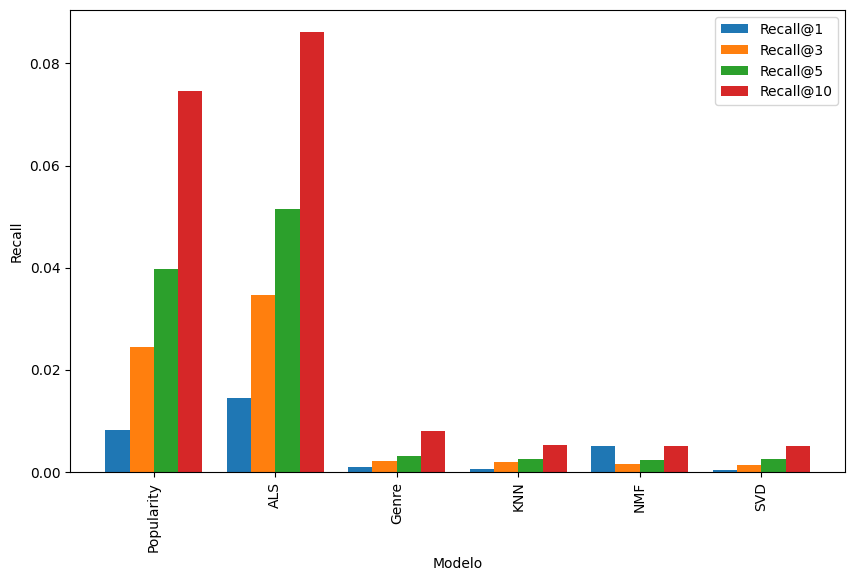

In [61]:
# Gráfico comparativo resultados recall@k

# Definir los valores y etiquetas para el eje x
modelos = data_recall['Modelo']
recalls_1 = data_recall['Recall@1']
recalls_3 = data_recall['Recall@3']
recalls_5 = data_recall['Recall@5']
recalls_10 = data_recall['Recall@10']

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Configurar las posiciones de las barras en el eje x
posiciones = list(range(len(modelos)))

# Crear las barras para cada métrica
plt.bar(posiciones, recalls_1, width=0.2, label='Recall@1')
plt.bar([p + 0.2 for p in posiciones], recalls_3, width=0.2, label='Recall@3')
plt.bar([p + 0.4 for p in posiciones], recalls_5, width=0.2, label='Recall@5')
plt.bar([p + 0.6 for p in posiciones], recalls_10, width=0.2, label='Recall@10')

# Configurar las etiquetas de los ejes x e y
plt.xlabel('Modelo')
plt.ylabel('Recall')

# Configurar las etiquetas del eje x y la orientación
plt.xticks([p + 0.3 for p in posiciones], modelos, rotation='vertical')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [62]:
# Transponer el dataframe
data_recall_T = data_recall.set_index('Modelo').T
data_recall_T

Modelo,Popularity,ALS,Genre,KNN,NMF,SVD
Recall@1,0.0082,0.0144,0.0009,0.0005,0.0050,0.0004
Recall@3,0.0245,0.0346,0.0022,0.0019,0.0015,0.0014
Recall@5,0.0397,0.0515,0.0032,0.0026,0.0023,0.0026
Recall@10,0.0747,0.0862,0.0081,0.0053,0.0051,0.0051


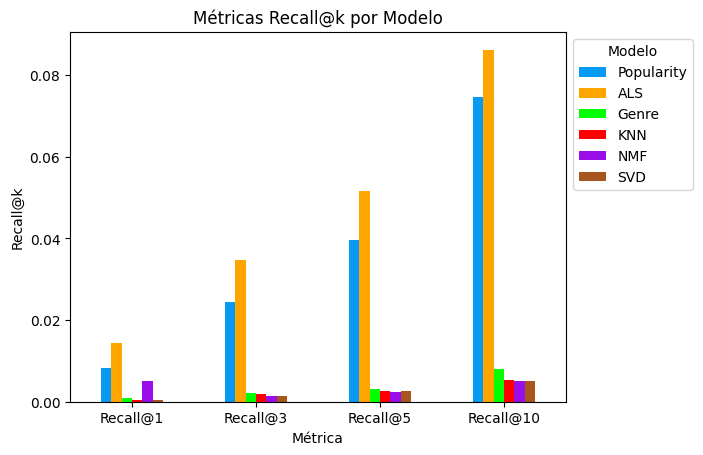

In [63]:
# Definir los colores para cada modelo
colors = ['#069AF3', 'orange', '#00FF00', '#FF0000', '#9A0EEA', '#A9561E']

# Crear el gráfico de barras agrupadas
data_recall_T.plot(kind='bar', color=colors)

# Configurar el gráfico
plt.title('Métricas Recall@k por Modelo')
plt.xlabel('Métrica')
plt.ylabel('Recall@k')
plt.legend(title='Modelo', bbox_to_anchor=(1.27, 1))
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


**Precision@k**

In [64]:
# Tabla precision@k
data_precision = {
    'Modelo': ['Popularity', 'ALS', 'Genre', 'KNN', 'NMF', 'SVD'],
    'Precision@1': [0.2157, 0.3001, 0.0212, 0.0392, 0.0371, 0.0382],
    'Precision@3': [0.2113, 0.2584, 0.0216, 0.0428, 0.0410, 0.0410],
    'Precision@5': [0.2157, 0.2414, 0.0189, 0.0373, 0.0388, 0.0416],
    'Precision@10': [0.1959, 0.2141, 0.0301, 0.0378, 0.0387, 0.0385]
}

data_precision = pd.DataFrame(data_precision)
data_precision

,Modelo,Precision@1,Precision@3,Precision@5,Precision@10
0,Popularity,0.2157,0.2113,0.2157,0.1959
1,ALS,0.3001,0.2584,0.2414,0.2141
2,Genre,0.0212,0.0216,0.0189,0.0301
3,KNN,0.0392,0.0428,0.0373,0.0378
4,NMF,0.0371,0.0410,0.0388,0.0387
5,SVD,0.0382,0.0410,0.0416,0.0385


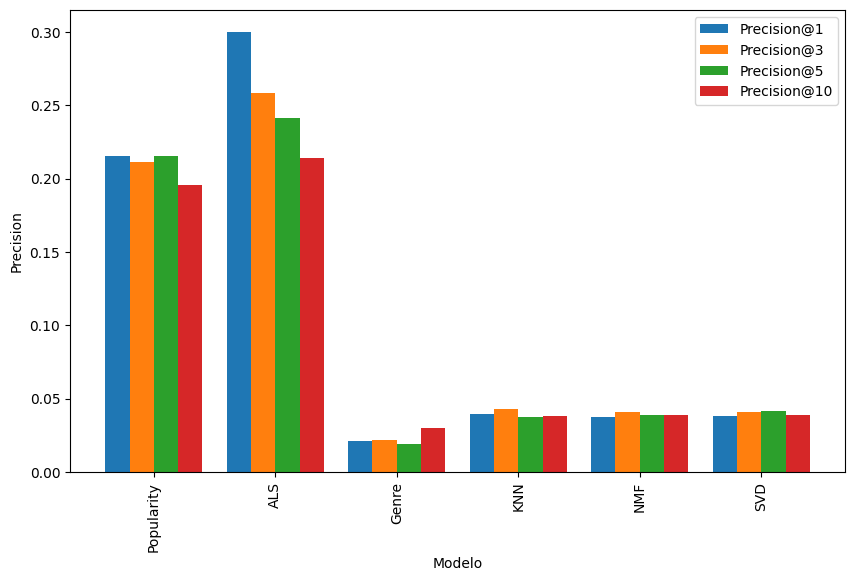

In [65]:
# Gráfico comparativo resultados precision@k

# Definir los valores y etiquetas para el eje x
modelos = data_precision['Modelo']
precision_1 = data_precision['Precision@1']
precision_3 = data_precision['Precision@3']
precision_5 = data_precision['Precision@5']
precision_10 = data_precision['Precision@10']

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Configurar las posiciones de las barras en el eje x
posiciones = list(range(len(modelos)))

# Crear las barras para cada métrica
plt.bar(posiciones, precision_1, width=0.2, label='Precision@1')
plt.bar([p + 0.2 for p in posiciones], precision_3, width=0.2, label='Precision@3')
plt.bar([p + 0.4 for p in posiciones], precision_5, width=0.2, label='Precision@5')
plt.bar([p + 0.6 for p in posiciones], precision_10, width=0.2, label='Precision@10')

# Configurar las etiquetas de los ejes x e y
plt.xlabel('Modelo')
plt.ylabel('Precision')

# Configurar las etiquetas del eje x y la orientación
plt.xticks([p + 0.3 for p in posiciones], modelos, rotation='vertical')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [66]:
# Transponer el dataframe
data_precision_T = data_precision.set_index('Modelo').T
data_precision_T

Modelo,Popularity,ALS,Genre,KNN,NMF,SVD
Precision@1,0.2157,0.3001,0.0212,0.0392,0.0371,0.0382
Precision@3,0.2113,0.2584,0.0216,0.0428,0.0410,0.0410
Precision@5,0.2157,0.2414,0.0189,0.0373,0.0388,0.0416
Precision@10,0.1959,0.2141,0.0301,0.0378,0.0387,0.0385


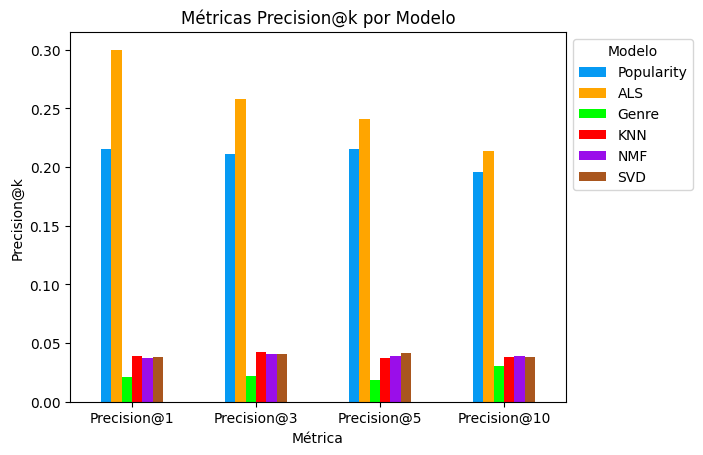

In [67]:
# Definir los colores para cada modelo
colors = ['#069AF3', 'orange', '#00FF00', '#FF0000', '#9A0EEA', '#A9561E']

# Crear el gráfico de barras agrupadas
data_precision_T.plot(kind='bar', color=colors)

# Configurar el gráfico
plt.title('Métricas Precision@k por Modelo')
plt.xlabel('Métrica')
plt.ylabel('Precision@k')
plt.legend(title='Modelo', bbox_to_anchor=(1.27, 1))
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


**Map@k**

In [68]:
# Tabla map@k
data_map = {
    'Modelo': ['Popularity', 'ALS', 'Genre', 'KNN', 'NMF', 'SVD'],
    'MAP@1': [0.2157, 0.3001, 0.0212, 0.0392, 0.0297, 0.0382],
    'MAP@3': [0.1496, 0.2293, 0.0150, 0.0287, 0.0268, 0.0275],
    'MAP@5': [0.1283, 0.1975, 0.0116, 0.0212, 0.0211, 0.0222],
    'MAP@10': [0.0953, 0.1583, 0.0101, 0.0153, 0.0154, 0.0160]
}

data_map = pd.DataFrame(data_map)
data_map

,Modelo,MAP@1,MAP@3,MAP@5,MAP@10
0,Popularity,0.2157,0.1496,0.1283,0.0953
1,ALS,0.3001,0.2293,0.1975,0.1583
2,Genre,0.0212,0.0150,0.0116,0.0101
3,KNN,0.0392,0.0287,0.0212,0.0153
4,NMF,0.0297,0.0268,0.0211,0.0154
5,SVD,0.0382,0.0275,0.0222,0.0160


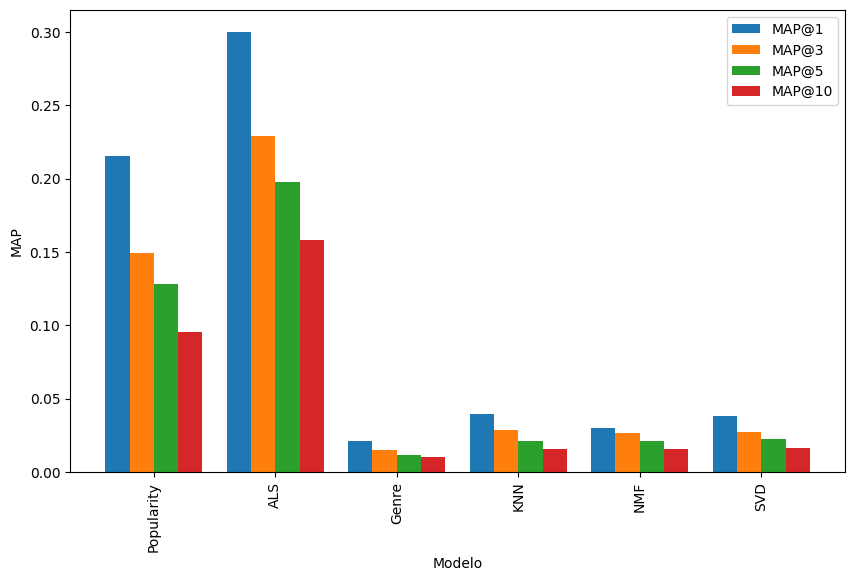

In [69]:
# Gráfico comparativo resultados map@k

# Definir los valores y etiquetas para el eje x
modelos = data_map['Modelo']
map_1 = data_map['MAP@1']
map_3 = data_map['MAP@3']
map_5 = data_map['MAP@5']
map_10 = data_map['MAP@10']

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Configurar las posiciones de las barras en el eje x
posiciones = list(range(len(modelos)))

# Crear las barras para cada métrica
plt.bar(posiciones, map_1, width=0.2, label='MAP@1')
plt.bar([p + 0.2 for p in posiciones], map_3, width=0.2, label='MAP@3')
plt.bar([p + 0.4 for p in posiciones], map_5, width=0.2, label='MAP@5')
plt.bar([p + 0.6 for p in posiciones], map_10, width=0.2, label='MAP@10')

# Configurar las etiquetas de los ejes x e y
plt.xlabel('Modelo')
plt.ylabel('MAP')

# Configurar las etiquetas del eje x y la orientación
plt.xticks([p + 0.3 for p in posiciones], modelos, rotation='vertical')

# Agregar una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [70]:
# traspongo el dataframe para hacer el grafico
data_map_T = data_map.set_index('Modelo').T
data_map_T

Modelo,Popularity,ALS,Genre,KNN,NMF,SVD
MAP@1,0.2157,0.3001,0.0212,0.0392,0.0297,0.0382
MAP@3,0.1496,0.2293,0.0150,0.0287,0.0268,0.0275
MAP@5,0.1283,0.1975,0.0116,0.0212,0.0211,0.0222
MAP@10,0.0953,0.1583,0.0101,0.0153,0.0154,0.0160


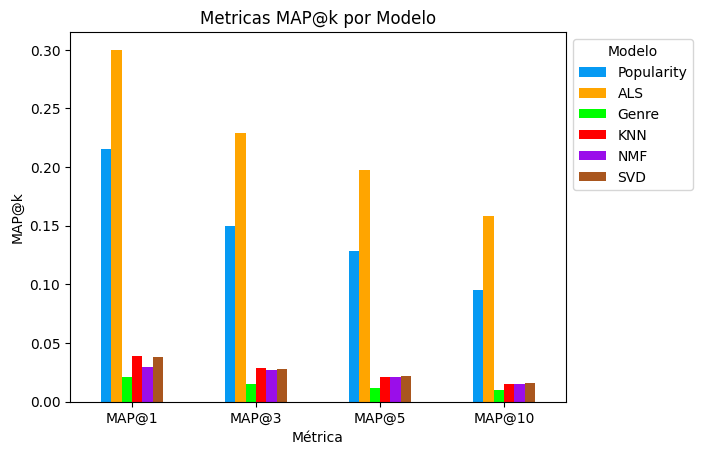

In [71]:
# Definir los colores para cada modelo
colors = ['#069AF3', 'orange', '#00FF00', '#FF0000', '#9A0EEA', '#A9561E']

# Crear el gráfico de barras agrupadas
data_map_T.plot(kind='bar', color=colors)

# Configurar el gráfico
plt.title('Metricas MAP@k por Modelo')
plt.xlabel('Métrica')
plt.ylabel('MAP@k')
plt.legend(title='Modelo', bbox_to_anchor=(1.27, 1))
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


In [72]:
# # Paso las tablas de las métricas a un excel para modificar el formato
# #import openpyxl

# ruta_base = 'C:/Users/Jose/Documents/1-CUNEF/TFM/1-recomendacion'

# # Guarda los DataFrames en el mismo archivo de Excel con diferentes hojas
# with pd.ExcelWriter(ruta_base + '.xlsx', engine='openpyxl') as writer:
#     data_recall.to_excel(writer, sheet_name='Recall', index=False)
#     data_precision.to_excel(writer, sheet_name='Precision', index=False)
#     data_map.to_excel(writer, sheet_name='MAP', index=False)
